In [1]:
## Beta recommender system

In [2]:
import pandas as pd
import numpy as np

In [3]:
%%time
# Load reviews
reviews = pd.read_csv('../data/yelp_reviews_restaurant.csv')
reviews.head()

Wall time: 37.2 s


,user_id,business_id,review_stars,text,date,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories
0,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11,Deagan's Kitchen & Bar,14810 Detroit Ave,Lakewood,OH,44107,41.485192,-81.800145,4.0,"{'BusinessAcceptsCreditCards': 'True', 'Outdoo...",American
1,zFCuveEe6M-ijY1iy23IJg,HQl28KMwrEKHqhFrrDqVNQ,5,"We walked into Melt. ""Did you want to put your...",2011-08-25 04:24:23,Deagan's Kitchen & Bar,14810 Detroit Ave,Lakewood,OH,44107,41.485192,-81.800145,4.0,"{'BusinessAcceptsCreditCards': 'True', 'Outdoo...",American
2,4V985R3RG-rv0B7WCPQzeQ,HQl28KMwrEKHqhFrrDqVNQ,1,I commented on how slow the service was last A...,2015-03-04 20:37:43,Deagan's Kitchen & Bar,14810 Detroit Ave,Lakewood,OH,44107,41.485192,-81.800145,4.0,"{'BusinessAcceptsCreditCards': 'True', 'Outdoo...",American
3,nFGcoL6wuPQzxsNJVSfGrA,HQl28KMwrEKHqhFrrDqVNQ,4,We walked in off the streets on a September ni...,2014-09-10 01:38:55,Deagan's Kitchen & Bar,14810 Detroit Ave,Lakewood,OH,44107,41.485192,-81.800145,4.0,"{'BusinessAcceptsCreditCards': 'True', 'Outdoo...",American
4,CJqgUQeWhdgbDyLAFy7xvQ,HQl28KMwrEKHqhFrrDqVNQ,4,Brunch on Saturday was excellent. The Bloody M...,2018-01-21 18:50:29,Deagan's Kitchen & Bar,14810 Detroit Ave,Lakewood,OH,44107,41.485192,-81.800145,4.0,"{'BusinessAcceptsCreditCards': 'True', 'Outdoo...",American


In [4]:
# As seen is the EDA, there are a lot of users which does very few reviews. 
# That makes really difficult to classify and with the big amount of data, it is also needed to remove some values. 
# Therefore in order to be in the model, a threshold of 50 reviews/user has been selected. 

In [5]:
# Remove users that have less than 50 reviews.
grouped_users = reviews.groupby('user_id')['text'].count().reset_index()
grouped_users.head()

,user_id,text
0,---1lKK3aKOuomHnwAkAow,27
1,---94vtJ_5o_nikEs6hUjg,1
2,---RfKzBwQ8t3wu-LXvx3w,1
3,---tGbMnMitD_7srW6Nfzg,1
4,---udAKDsn0yQXmzbWQNSw,1


In [6]:
result = grouped_users.query('text <= 50')
result['text'].sum()

2785830

In [7]:
reviews.shape[0]

3140427

In [8]:
print(f'Difference: {reviews.shape[0] - result["text"].sum()}')

Difference: 354597


In [9]:
reviews_filtered = reviews[['user_id', 'name', 'review_stars']][~reviews['user_id'].isin(result['user_id'])]
reviews_filtered.shape

(354596, 3)

## Recommender system using reviews as values

In [10]:
## Utility matrix for users (for restaurants take utility_matrix.T)
from scipy.sparse import csr_matrix

utility_matrix = reviews_filtered.pivot_table(index='user_id', values='review_stars', columns='name').fillna(0)
um = csr_matrix(utility_matrix) 

In [11]:
restaurant_ids = (utility_matrix.columns)
users_ids = (utility_matrix.index)

In [12]:
# Normalizing the data

sum_ratings_per_restaurant = um.sum(axis=0)
n_ratings_per_restaurant = um.getnnz(axis=0)
mean_rating_per_restaurant = sum_ratings_per_restaurant / n_ratings_per_restaurant

In [13]:
um_mean_restaurant = np.tile(mean_rating_per_restaurant, (um.shape[0],1))
um_mean_restaurant.shape

(4006, 14149)

In [14]:
um_norm = um - csr_matrix(um_mean_restaurant)

In [15]:
# Comparing after and before normalizing

um.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
um_norm.todense()

matrix([[-3.        , -2.6       , -3.8       , ..., -5.        ,
         -4.        , -3.66666667],
        [-3.        , -2.6       , -3.8       , ..., -5.        ,
         -4.        , -3.66666667],
        [-3.        , -2.6       , -3.8       , ..., -5.        ,
         -4.        , -3.66666667],
        ...,
        [-3.        , -2.6       , -3.8       , ..., -5.        ,
         -4.        , -3.66666667],
        [-3.        , -2.6       , -3.8       , ..., -5.        ,
         -4.        , -3.66666667],
        [-3.        , -2.6       , -3.8       , ..., -5.        ,
         -4.        , -3.66666667]])

In [17]:
# create the cosine_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(um_norm, um_norm)

In [18]:
## Restaurant recomendation (item-item) with k-NN

In [19]:
from sklearn.neighbors import NearestNeighbors

In [20]:
names = reviews_filtered['name']
restaurant_ids = reviews_filtered.index

def recommendations(restaurant, distance, k=10):
    correct_name = reviews_filtered[reviews_filtered.name.str.contains(restaurant)]['name'].values[0]
    idx = restaurant_ids.get_loc(reviews_filtered[reviews_filtered.name.str.contains(restaurant)]['name'].index[0])
    
    sim_scores = list(enumerate(distance[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:k]
    
    similar_restaurants = [i[0] for i in sim_scores]
    
    print(f'Recommendations for {correct_name}')
    return reviews_filtered['name'].iloc[similar_restaurants]

In [23]:
recommendations('Liberty', cosine_sim, k=20)

IndexError: index 4473 is out of bounds for axis 0 with size 4006

In [22]:
recommendations('Pollo Loco', cosine_sim, k=15)

Recommendations for El Pollo Loco


8061        Diamond Restaurant
32153    Tomo Japanese Cuisine
34265             Asian Legend
15272         Everyday Noodles
20827       Wonton Chai Noodle
32398              Le Gourmand
26682         Joe's Farm Grill
29894        Yasu Sushi Bistro
12670               StripSteak
30205            Tacos Sahuaro
26011                  Bouchon
20368           Sonic Drive-In
10894            Chop Chop Wok
21750              Dragon Town
Name: name, dtype: object

In [24]:
cosine_sim.shape

(4006, 4006)

### Dimension reduction

In [25]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

def optimal_dimensions_svd(matrix):
    n_comp = [2,4,7,10,15,20,50,100,150,200,500,700,800,900,1000,1500,2000,2500,3000,3500,4000] # list containing different values of components
    explained = [] # explained variance ratio for each component of Truncated SVD
    for x in n_comp:
        svd = TruncatedSVD(n_components=x, n_iter=10)
        svd.fit(matrix)
        explained.append(svd.explained_variance_ratio_.sum())
        print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
    plt.plot(n_comp, explained)
    plt.xlabel('Number of components')
    plt.ylabel("Explained Variance")
    plt.title("Plot of Number of components v/s explained variance")
    plt.show()

In [26]:
cosine_sim.shape[0]

4006

Number of components = 2 and explained variance = 0.9801189917870281
Number of components = 4 and explained variance = 0.9888182973245369
Number of components = 7 and explained variance = 0.9916988654028565
Number of components = 10 and explained variance = 0.992607373909319
Number of components = 15 and explained variance = 0.9934736650407323
Number of components = 20 and explained variance = 0.9939523849585676
Number of components = 50 and explained variance = 0.9952266808878341
Number of components = 100 and explained variance = 0.9962098870824404
Number of components = 150 and explained variance = 0.9968180883960654
Number of components = 200 and explained variance = 0.997258269347349
Number of components = 500 and explained variance = 0.9986260998304227
Number of components = 700 and explained variance = 0.9990645647300513
Number of components = 800 and explained variance = 0.9992192720418471
Number of components = 900 and explained variance = 0.9993449773729882
Number of componen

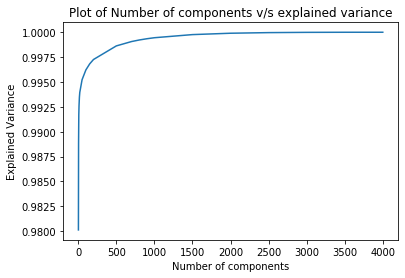

In [27]:
optimal_dimensions_svd(cosine_sim)

In [ ]:
# The selected number is 10 which explains a 99% of the variance.

In [28]:
svd = TruncatedSVD(n_components=10, n_iter=10)
Z = svd.fit_transform(cosine_sim)

Number of components = 2 and explained variance = 0.04157976025691141
Number of components = 4 and explained variance = 0.06694717730238406
Number of components = 7 and explained variance = 0.0921774654360384
Number of components = 10 and explained variance = 0.10599314924961847
Number of components = 15 and explained variance = 0.12353347029229107
Number of components = 20 and explained variance = 0.13683274110452445
Number of components = 50 and explained variance = 0.19089943670107842
Number of components = 100 and explained variance = 0.25311508390191
Number of components = 150 and explained variance = 0.30229071357686965
Number of components = 200 and explained variance = 0.3441442262944723
Number of components = 500 and explained variance = 0.5237733358717821
Number of components = 700 and explained variance = 0.6077370768121786
Number of components = 800 and explained variance = 0.6430672178810096
Number of components = 900 and explained variance = 0.6749244508382675
Number of c

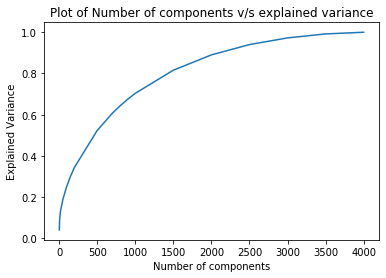

In [32]:
# The number of components has increased... now are 3000
optimal_dimensions_svd(utility_matrix)

In [33]:
svd = TruncatedSVD(n_components=3000, n_iter=10)
cf = svd.fit_transform(utility_matrix)

In [34]:
cf_inv = svd.inverse_transform(cf).T
cf_inv

array([[-0.00793383, -0.00053581,  0.02692854, ..., -0.00409359,
        -0.00417807,  0.0007716 ],
       [-0.01124291,  0.06254465,  0.00669541, ...,  0.00407962,
        -0.01559481,  0.00317272],
       [-0.0170828 , -0.00530238,  0.00082722, ..., -0.01111826,
         0.00900144,  0.00909887],
       ...,
       [-0.00110778, -0.00549144,  0.0020523 , ...,  0.00600018,
         0.00257069, -0.00290976],
       [-0.0027492 ,  0.01488567, -0.00279907, ..., -0.01055194,
         0.00228021, -0.00045709],
       [-0.00066829, -0.00337797,  0.00464784, ...,  0.00745418,
        -0.00136384, -0.00501976]])

### Predicting missing ratings to generate top N recommendations

In [29]:
new_X = svd.inverse_transform(Z).T

In [35]:
def user_recomendations(user_id, k=10):
    idx_loc = utility_matrix.index.get_loc(user_id)
    rec = pd.DataFrame(list(zip(reviews_filtered['name'], 
                                utility_matrix.loc[user_id], 
                                cf_inv[idx_loc, :])), 
                       columns=['restaurant', 'stars', 'pred'])
    return rec[rec.stars==0].sort_values('pred', ascending=False).head(k)

In [36]:
user_recomendations('zFCuveEe6M-ijY1iy23IJg')

,restaurant,stars,pred
2628,Mama Gina's Pizzeria,0.0,3.981671
1168,Jackie Bee Boba Express,0.0,3.787555
1903,Akaihana Sushi & Grill,0.0,3.274459
479,Joe's Farm Grill,0.0,2.924332
1101,Otro Cafe,0.0,2.896428
920,Sansotei,0.0,0.387585
1816,Cocos Locos,0.0,0.349992
929,Cabo Fish Taco,0.0,0.324478
3203,Egg N' Joe,0.0,0.300741
2831,LeonÃ© CafÃ©,0.0,0.255335


In [37]:
user_recomendations('--Qh8yKWAvIP4V4K8ZPfHA')

,restaurant,stars,pred
944,Cabo Fish Taco,0.0,3.687070
3909,Stella Mia Ristorante,0.0,2.978179
1316,Crescent Ballroom,0.0,2.625018
3698,Yu Seafood,0.0,1.923164
3949,Wonton King,0.0,0.958079
2640,Blue Hound,0.0,0.240701
1288,The Cheesecake Factory,0.0,0.204482
489,Joe's Farm Grill,0.0,0.150649
3557,Mr. Brews Taphouse-West Madison,0.0,0.147865
3429,Li's Asian,0.0,0.136873


In [38]:
user_recomendations('-0b84SUGVN0YkG5j2MCmBw')

,restaurant,stars,pred
1720,Cafe Sanuki,0.0,3.992510
1042,Fajitas A Sizzlin Celebration,0.0,3.980332
3051,The Clever Koi,0.0,3.974655
1701,Letty's,0.0,3.970542
3368,Pescado Borracho,0.0,2.928411
3997,Otro Cafe,0.0,0.108822
2105,Jacks Place,0.0,0.103031
1957,Fudao noodle house,0.0,0.050229
2416,Sakana,0.0,0.049155
53,Beckett's Table,0.0,0.049009


In [39]:
utility_matrix.loc['zFCuveEe6M-ijY1iy23IJg']

name
 China                                 0.0
&Company Resto Bar                     0.0
1 Pot                                  0.0
100th Bomb Group                       0.0
107 State                              0.0
                                      ... 
Ã‰rabliÃ¨re Ã  la Feuille d'Ã‰rable    0.0
Ã‰tat-Major                            0.0
Ã‰toile Rouge                          0.0
Ã‰tudiant Savoureux Biryani            0.0
Å’ufs & Cie                            0.0
Name: zFCuveEe6M-ijY1iy23IJg, Length: 14149, dtype: float64

In [ ]:
utility_matrix.index.get_loc('zFCuveEe6M-ijY1iy23IJg')

In [ ]:
new_X[3309, :]

In [ ]:
utility_matrix.head()

In [ ]:
cosine_sim

In [ ]:
# Reminder: Apply the algorith (SVD) to the utility matrix, not de cosine_sim distance!!!!

In [42]:
# Evaluation metrics

#from funcsigs import signature
import recmetrics
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split

In [43]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews_filtered, reader)
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

In [44]:
# train SVD recommender
algo = SVD(n_factors=3000, n_epochs=10)
algo.fit(trainset)

In [45]:
# make predictions on test set

test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userid', 'restaurant', 'actual', 'cf_predictions']
test.head()

,userid,restaurant,actual,cf_predictions
0,4ZkQwaOoLT2eJWux9fE1Jw,KINTON RAMEN,3.0,3.156506
1,36uY0YLHy70zR7YoXLUKSA,Majerle's Sports Grill,4.0,3.654077
2,kbfpED-6FURIsNlsAXqc2g,Red Lobster,5.0,3.318354
3,O3pSxv1SyHpY4qi4Q16KzA,School Restaurant,3.0,3.618388
4,Oz1Tz4LUlLw_UAgEkUiCvw,Luciano's Ristorante Italiano,5.0,3.633401


In [46]:
# evaluate model with MSE and RMSE

print(f'MSE: {recmetrics.mse(test.actual, test.cf_predictions)}')
print(f'RMSE: {recmetrics.rmse(test.actual, test.cf_predictions)}')

MSE: 1.060427550101276
RMSE: 1.0297706298498108


In [56]:
test_svd = test.copy()

In [66]:
def get_users_predictions(userid, n, model):
    recommended_items = model[['restaurant', 'actual', 'cf_predictions']][model.userid == userid]
    recommended_items = recommended_items.sort_values('cf_predictions', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items

In [67]:
get_users_predictions('4ZkQwaOoLT2eJWux9fE1Jw', 10, test_svd)

,restaurant,actual,cf_predictions
80943,Rito's Mexican Food- Phoenix,5.0,4.960147
20507,King's Noodle Restaurant,4.0,4.054475
42313,China Chili,4.0,3.995283
4987,Mu Shu Asian Grill,4.0,3.987240
85144,The Fry Bread House,4.0,3.983806
39569,Friday's Front Row Sports Grill,4.0,3.978372
71169,Snoh Ice Shavery,4.0,3.974140
46161,The Yard,4.0,3.966975
5460,The Yard,4.0,3.966975
77624,Cherryblossom Noodle Cafe,2.0,3.935642


In [ ]:
# create matrix of predicted values

cf_model = test.pivot(index='userid', columns='restaurant', values='cf_predictions').fillna(0)

In [ ]:
test

In [ ]:
test[test.duplicated()]

## Recommender system using NLP